In [1]:
import os
import pickle
import pandas as pd
import glob
from tqdm import tqdm, trange
import joblib

# math imports
import numpy as np
import scipy
import sklearn

import warnings
import matplotlib
from matplotlib import pyplot
import seaborn as sns

import copy
from functools import reduce

from dataclasses import dataclass

from method.ICQF.ICQF import ICQF
import sys

from sklearn.cluster import AgglomerativeClustering

In [2]:
@dataclass
class matrix_class:

    M : np.ndarray # (column)-normalized data matrix
    M_raw : np.ndarray # raw data matrix
    confound : np.ndarray # normalized confounder matrix
    confound_raw : np.ndarray # raw confounder matrix
    nan_mask : np.ndarray # mask matrix for missing entires (0=missing, 1=available)
    row_idx : np.ndarray # global row index (for multiple data matrices)
    col_idx : np.ndarray # global column index (for multiple data matrices)
    mask : np.ndarray # global mask (for multiple data matrices)
    dataname : str # dataname
    subjlist : list # information on subjects (row information)
    itemlist : list # information on items (column information)
    W : np.ndarray # subject embedding (recall M = [W, C]Q^T)
    Q : np.ndarray # item embedding (recall M = [W, C]Q^T)
    C : np.ndarray # confounder matrix
    Qc : np.ndarray # confounders' loadings (recall Q = [RQ, CQ])
    Z : np.ndarray # auxiliary Z=WQ^T (ADMM)
    aZ : np.ndarray # auxiliary variables (ADMM)


### Data loading

In [3]:
question_list = pd.read_csv('./data/snycq.csv').columns[2:]
question_list

Index(['Positive', 'Negative', 'Future', 'Past', 'Myself', 'People',
       'Surroundings', 'Images', 'Words', 'Specific', 'Intrusive'],
      dtype='object')

In [4]:
demo_csv = pd.read_csv('./data/participants_post_motion_QA.csv')
data_csv = pd.read_csv('./data/snycq.csv')

In [5]:
data_csv

,Subject,Run,Positive,Negative,Future,Past,Myself,People,Surroundings,Images,Words,Specific,Intrusive
0,sub-010014,post-ses-02-run-01-acq-AP,80.0,15.0,50.0,55.0,30.0,65.0,55.0,95.0,90.0,25.0,30.0
1,sub-010014,post-ses-02-run-01-acq-PA,60.0,10.0,75.0,70.0,65.0,65.0,80.0,95.0,85.0,25.0,55.0
2,sub-010014,post-ses-02-run-02-acq-AP,55.0,60.0,65.0,40.0,50.0,60.0,65.0,75.0,85.0,30.0,60.0
3,sub-010014,post-ses-02-run-02-acq-PA,40.0,55.0,95.0,5.0,55.0,60.0,60.0,80.0,90.0,30.0,55.0
4,sub-010080,post-ses-02-run-02-acq-AP,75.0,20.0,50.0,30.0,35.0,70.0,75.0,70.0,50.0,40.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,sub-010077,post-ses-02-run-02-acq-AP,75.0,5.0,75.0,45.0,25.0,80.0,40.0,65.0,20.0,10.0,5.0
467,sub-010077,post-ses-02-run-02-acq-PA,50.0,55.0,55.0,80.0,55.0,75.0,20.0,85.0,25.0,55.0,60.0
468,sub-010078,post-ses-02-run-01-acq-PA,85.0,35.0,85.0,45.0,40.0,75.0,55.0,55.0,15.0,45.0,40.0
469,sub-010078,post-ses-02-run-02-acq-AP,60.0,30.0,85.0,20.0,45.0,60.0,45.0,60.0,15.0,40.0,40.0


In [6]:
os.makedirs('./output/factorization_javier', exist_ok=True)

### With confound modeling
- configuration (d = 2, betaW = 0.0, betaQ = 0.01) [optimal]

In [96]:
data = np.load('./output/full_data.npz')
M = data['M']
nan_mask = data['nan_mask']
confound = data['confound']
MF_data = matrix_class(M, None, confound, None, nan_mask, None, None,
                       None, None, None, None, None, None,
                       None, None, None, None)

clf = ICQF(2, rho=3, tau=3, regularizer=1,
                        W_upperbd=(True, 1.0),
                        Q_upperbd=(True, 100),
                        M_upperbd=(True, 100),
                        W_beta=0.0,
                        Q_beta=0.01,
                        max_iter=200)
MF_data, loss_list = clf.fit_transform(MF_data)

In [97]:
np.savez('./output/factorization/factorization_fulldata_confound_optimal.npz',
         M=M,
         confound=confound,
         W=MF_data.W,
         Q=MF_data.Q,
         C=MF_data.C,
         Qc=MF_data.Qc,
         subjlist=list(data_csv['Subject'].values),
         runlist=list(data_csv['Run'].values))

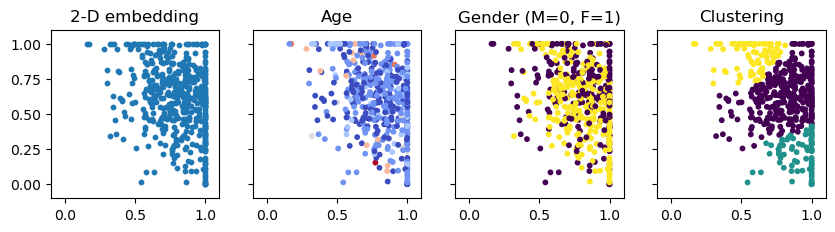

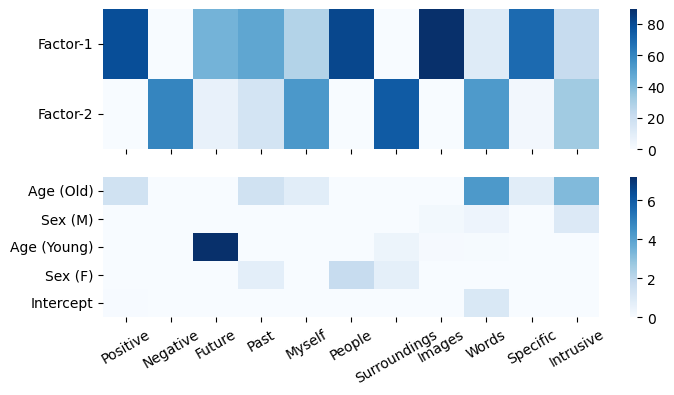

In [98]:

fig, ax = pyplot.subplots(ncols=4, nrows=1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].scatter(MF_data.W[:,0], MF_data.W[:,1], s=10)
ax[0].set_xlim([-0.1, 1.1])
ax[0].set_ylim([-0.1, 1.1])
ax[0].set_aspect('equal', 'box')
ax[0].set_title('2-D embedding')
ax[1].scatter(MF_data.W[:,0], MF_data.W[:,1], c=MF_data.confound[:,0], cmap='coolwarm', s=10)
ax[1].set_xlim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
ax[1].set_aspect('equal', 'box')
ax[1].set_title('Age')
ax[2].scatter(MF_data.W[:,0], MF_data.W[:,1], c=MF_data.confound[:,1], s=10)
ax[2].set_xlim([-0.1, 1.1])
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_aspect('equal', 'box')
ax[2].set_title('Gender (M=0, F=1)')

clustering = AgglomerativeClustering(n_clusters=3).fit(MF_data.W)
ax[3].scatter(MF_data.W[:,0], MF_data.W[:,1], c=clustering.labels_, s=10)
ax[3].set_xlim([-0.1, 1.1])
ax[3].set_ylim([-0.1, 1.1])
ax[3].set_aspect('equal', 'box')
ax[3].set_title('Clustering')

pyplot.show()

fig, ax = pyplot.subplots(ncols=1, nrows=2, figsize=(8, 4), sharex=True)
sns.heatmap(MF_data.Q.T, cmap='Blues', ax=ax[0])
ax[0].set_xticks(np.arange(11)+0.5)
ax[0].set_xticklabels(question_list, rotation=30)
ax[0].set_yticks([0.5,1.5])
ax[0].set_yticklabels(['Factor-1', 'Factor-2'], rotation=0)

sns.heatmap(MF_data.Qc.T, cmap='Blues', ax=ax[1])
ax[1].set_xticks(np.arange(11)+0.5)
ax[1].set_xticklabels(question_list, rotation=30)
ax[1].set_yticks(np.arange(5)+0.5)
ax[1].set_yticklabels(['Age (Old)', 'Sex (M)', 'Age (Young)', 'Sex (F)', 'Intercept'], rotation=0)
pyplot.show()

### With confound modeling
- configuration (d = 2, betaW = 0, betaQ = 0)

In [99]:
data = np.load('./output/full_data.npz')
M = data['M']
nan_mask = data['nan_mask']
confound = data['confound']
MF_data = matrix_class(M, None, confound, None, nan_mask, None, None,
                       None, None, None, None, None, None,
                       None, None, None, None)

clf = ICQF(2, rho=3, tau=3, regularizer=1,
                        W_upperbd=(True, 1.0),
                        Q_upperbd=(True, 100),
                        M_upperbd=(True, 100),
                        W_beta=0,
                        Q_beta=0,
                        max_iter=200)
MF_data, loss_list = clf.fit_transform(MF_data)

In [100]:
np.savez('./output/factorization/factorization_fulldata_confound.npz',
         M=M,
         confound=confound,
         W=MF_data.W,
         Q=MF_data.Q,
         C=MF_data.C,
         Qc=MF_data.Qc,
         subjlist=list(data_csv['Subject'].values),
         runlist=list(data_csv['Run'].values))

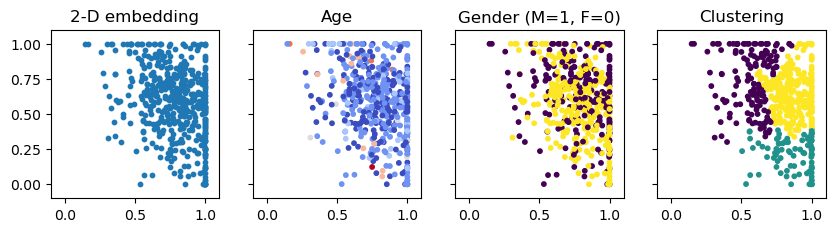

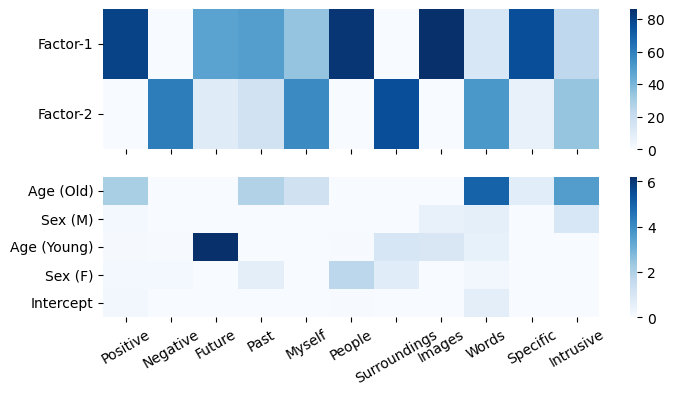

In [101]:
from sklearn.cluster import AgglomerativeClustering

fig, ax = pyplot.subplots(ncols=4, nrows=1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].scatter(MF_data.W[:,0], MF_data.W[:,1], s=10)
ax[0].set_xlim([-0.1, np.max(MF_data.W[:,0])+0.1])
ax[0].set_ylim([-0.1, np.max(MF_data.W[:,1])+0.1])
ax[0].set_aspect('equal', 'box')
ax[0].set_title('2-D embedding')
ax[1].scatter(MF_data.W[:,0], MF_data.W[:,1], c=MF_data.confound[:,0], cmap='coolwarm', s=10)
ax[0].set_xlim([-0.1, np.max(MF_data.W[:,0])+0.1])
ax[0].set_ylim([-0.1, np.max(MF_data.W[:,1])+0.1])
ax[1].set_aspect('equal', 'box')
ax[1].set_title('Age')
ax[2].scatter(MF_data.W[:,0], MF_data.W[:,1], c=MF_data.confound[:,1], s=10)
ax[0].set_xlim([-0.1, np.max(MF_data.W[:,0])+0.1])
ax[0].set_ylim([-0.1, np.max(MF_data.W[:,1])+0.1])
ax[2].set_aspect('equal', 'box')
ax[2].set_title('Gender (M=1, F=0)')

clustering = AgglomerativeClustering(n_clusters=3).fit(MF_data.W)
ax[3].scatter(MF_data.W[:,0], MF_data.W[:,1], c=clustering.labels_, s=10)
ax[0].set_xlim([-0.1, np.max(MF_data.W[:,0])+0.1])
ax[0].set_ylim([-0.1, np.max(MF_data.W[:,1])+0.1])
ax[3].set_aspect('equal', 'box')
ax[3].set_title('Clustering')

pyplot.show()

fig, ax = pyplot.subplots(ncols=1, nrows=2, figsize=(8, 4), sharex=True)
sns.heatmap(MF_data.Q.T, cmap='Blues', ax=ax[0])
ax[0].set_xticks(np.arange(11)+0.5)
ax[0].set_xticklabels(question_list, rotation=30)
ax[0].set_yticks([0.5,1.5])
ax[0].set_yticklabels(['Factor-1', 'Factor-2'], rotation=0)

sns.heatmap(MF_data.Qc.T, cmap='Blues', ax=ax[1])
ax[1].set_xticks(np.arange(11)+0.5)
ax[1].set_xticklabels(question_list, rotation=30)
ax[1].set_yticks(np.arange(5)+0.5)
ax[1].set_yticklabels(['Age (Old)', 'Sex (M)', 'Age (Young)', 'Sex (F)', 'Intercept'], rotation=0)
pyplot.show()

### Without confound modeling, without intercept
- configuration (d = 2, betaW = 0, betaQ = 0.1) [optimal]

In [9]:
data = np.load('./output/full_data.npz')
M = data['M']
nan_mask = data['nan_mask']
confound = data['confound']
age = confound[:,0]
gender = confound[:,1]
MF_data = matrix_class(M, None, None, None, nan_mask, None, None,
                       None, None, None, None, None, None,
                       None, None, None, None)

clf = ICQF(2, rho=3, tau=3, regularizer=1,
                        W_upperbd=(True, 1.0),
                        Q_upperbd=(True, 100),
                        M_upperbd=(True, 100),
                        W_beta=0.0,
                        Q_beta=0.01,
                        max_iter=200,
                        intercept=False)
MF_data, loss_list = clf.fit_transform(MF_data)

In [10]:
np.savez('./output/factorization_javier/factorization_fulldata_noconfound_nointercept_optimal.npz',
         M=M,
         confound=None,
         W=MF_data.W,
         Q=MF_data.Q,
         C=None,
         Qc=None,
         subjlist=list(data_csv['Subject'].values),
         runlist=list(data_csv['Run'].values))

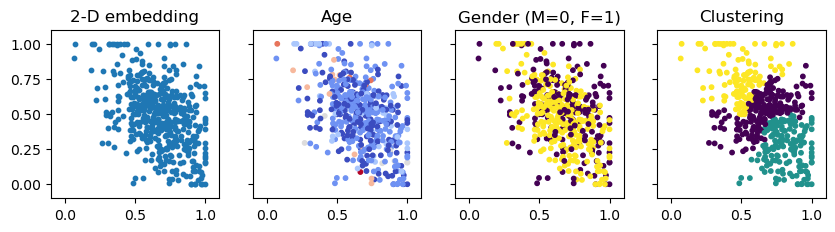

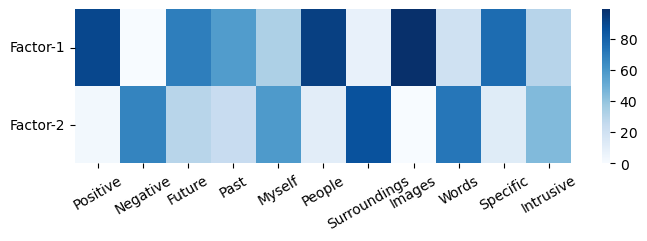

In [11]:
fig, ax = pyplot.subplots(ncols=4, nrows=1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].scatter(MF_data.W[:,0], MF_data.W[:,1], s=10)
ax[0].set_xlim([-0.1, 1.1])
ax[0].set_ylim([-0.1, 1.1])
ax[0].set_aspect('equal', 'box')
ax[0].set_title('2-D embedding')
ax[1].scatter(MF_data.W[:,0], MF_data.W[:,1], c=age, cmap='coolwarm', s=10)
ax[1].set_xlim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
ax[1].set_aspect('equal', 'box')
ax[1].set_title('Age')
ax[2].scatter(MF_data.W[:,0], MF_data.W[:,1], c=gender, s=10)
ax[2].set_xlim([-0.1, 1.1])
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_aspect('equal', 'box')
ax[2].set_title('Gender (M=0, F=1)')

clustering = AgglomerativeClustering(n_clusters=3).fit(MF_data.W)
ax[3].scatter(MF_data.W[:,0], MF_data.W[:,1], c=clustering.labels_, s=10)
ax[3].set_xlim([-0.1, 1.1])
ax[3].set_ylim([-0.1, 1.1])
ax[3].set_aspect('equal', 'box')
ax[3].set_title('Clustering')
pyplot.show()

fig, ax = pyplot.subplots(figsize=(8, 2))
sns.heatmap(MF_data.Q.T, cmap='Blues', ax=ax)
ax.set_xticks(np.arange(11)+0.5)
ax.set_xticklabels(question_list, rotation=30)
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(['Factor-1', 'Factor-2'], rotation=0)
pyplot.show()

### Without confound modeling, without intercept
- configuration (d = 2, betaW = 0, betaQ = 0)

In [81]:
data = np.load('./output/full_data.npz')
M = data['M']
nan_mask = data['nan_mask']
confound = data['confound']
age = confound[:,0]
gender = confound[:,1]
MF_data = matrix_class(M, None, None, None, nan_mask, None, None,
                       None, None, None, None, None, None,
                       None, None, None, None)

clf = ICQF(2, rho=3, tau=3, regularizer=1,
                        W_upperbd=(True, 1.0),
                        Q_upperbd=(True, 100),
                        M_upperbd=(True, 100),
                        W_beta=0.0,
                        Q_beta=0.0,
                        max_iter=200,
                        intercept=False)
MF_data, loss_list = clf.fit_transform(MF_data)

In [82]:
np.savez('./output/factorization/factorization_fulldata_noconfound_nointercept.npz',
         M=M,
         confound=None,
         W=MF_data.W,
         Q=MF_data.Q,
         C=None,
         Qc=None,
         subjlist=list(data_csv['Subject'].values),
         runlist=list(data_csv['Run'].values))

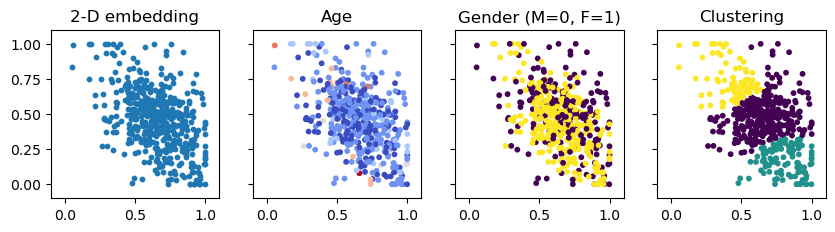

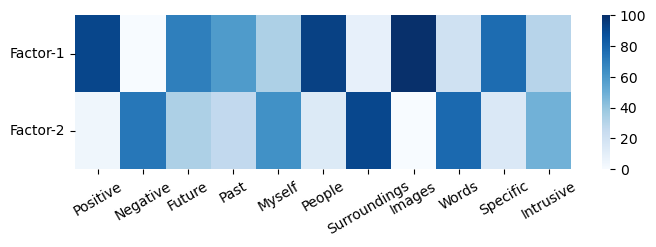

In [83]:
fig, ax = pyplot.subplots(ncols=4, nrows=1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].scatter(MF_data.W[:,0], MF_data.W[:,1], s=10)
ax[0].set_xlim([-0.1, 1.1])
ax[0].set_ylim([-0.1, 1.1])
ax[0].set_aspect('equal', 'box')
ax[0].set_title('2-D embedding')
ax[1].scatter(MF_data.W[:,0], MF_data.W[:,1], c=age, cmap='coolwarm', s=10)
ax[1].set_xlim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
ax[1].set_aspect('equal', 'box')
ax[1].set_title('Age')
ax[2].scatter(MF_data.W[:,0], MF_data.W[:,1], c=gender, s=10)
ax[2].set_xlim([-0.1, 1.1])
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_aspect('equal', 'box')
ax[2].set_title('Gender (M=0, F=1)')

clustering = AgglomerativeClustering(n_clusters=3).fit(MF_data.W)
ax[3].scatter(MF_data.W[:,0], MF_data.W[:,1], c=clustering.labels_, s=10)
ax[3].set_xlim([-0.1, 1.1])
ax[3].set_ylim([-0.1, 1.1])
ax[3].set_aspect('equal', 'box')
ax[3].set_title('Clustering')
pyplot.show()

fig, ax = pyplot.subplots(figsize=(8, 2))
sns.heatmap(MF_data.Q.T, cmap='Blues', ax=ax)
ax.set_xticks(np.arange(11)+0.5)
ax.set_xticklabels(question_list, rotation=30)
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(['Factor-1', 'Factor-2'], rotation=0)
pyplot.show()

### Without confound modeling, with intercept
- configuration (d = 2, betaW = 0, betaQ = 0.01) [optimal]

In [74]:
data = np.load('./output/full_data.npz')
M = data['M']
nan_mask = data['nan_mask']
confound = data['confound']
age = confound[:,0]
gender = confound[:,1]
MF_data = matrix_class(M, None, None, None, nan_mask, None, None,
                       None, None, None, None, None, None,
                       None, None, None, None)

clf = ICQF(2, rho=3, tau=3, regularizer=1,
                        W_upperbd=(True, 1.0),
                        Q_upperbd=(True, 100),
                        M_upperbd=(True, 100),
                        W_beta=0.0,
                        Q_beta=0.01,
                        max_iter=200,
                        intercept=True)
MF_data, loss_list = clf.fit_transform(MF_data)

In [75]:
np.savez('./output/factorization/factorization_fulldata_noconfound_optimal.npz',
         M=M,
         confound=None,
         W=MF_data.W,
         Q=MF_data.Q,
         C=None,
         Qc=None,
         subjlist=list(data_csv['Subject'].values),
         runlist=list(data_csv['Run'].values))

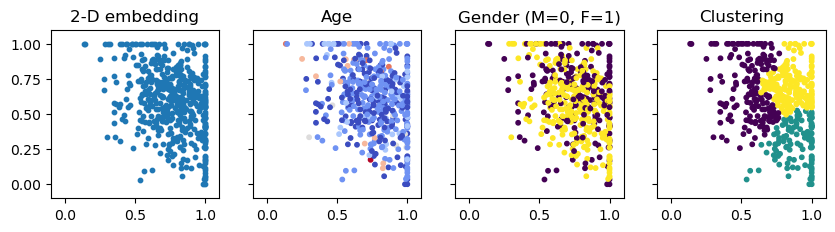

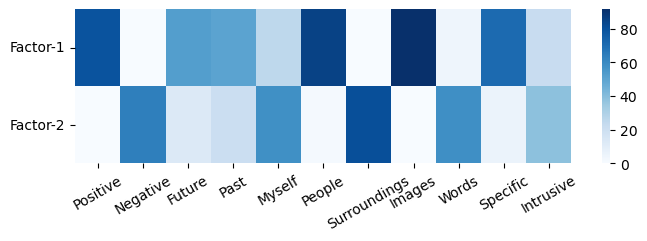

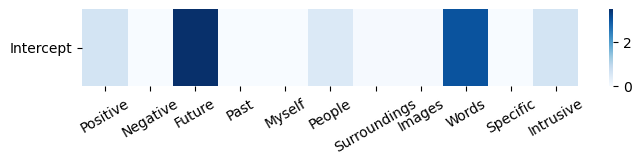

In [76]:
fig, ax = pyplot.subplots(ncols=4, nrows=1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].scatter(MF_data.W[:,0], MF_data.W[:,1], s=10)
ax[0].set_xlim([-0.1, 1.1])
ax[0].set_ylim([-0.1, 1.1])
ax[0].set_aspect('equal', 'box')
ax[0].set_title('2-D embedding')
ax[1].scatter(MF_data.W[:,0], MF_data.W[:,1], c=age, cmap='coolwarm', s=10)
ax[1].set_xlim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
ax[1].set_aspect('equal', 'box')
ax[1].set_title('Age')
ax[2].scatter(MF_data.W[:,0], MF_data.W[:,1], c=gender, s=10)
ax[2].set_xlim([-0.1, 1.1])
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_aspect('equal', 'box')
ax[2].set_title('Gender (M=0, F=1)')

clustering = AgglomerativeClustering(n_clusters=3).fit(MF_data.W)
ax[3].scatter(MF_data.W[:,0], MF_data.W[:,1], c=clustering.labels_, s=10)
ax[3].set_xlim([-0.1, 1.1])
ax[3].set_ylim([-0.1, 1.1])
ax[3].set_aspect('equal', 'box')
ax[3].set_title('Clustering')
pyplot.show()

fig, ax = pyplot.subplots(figsize=(8, 2))
sns.heatmap(MF_data.Q.T, cmap='Blues', ax=ax)
ax.set_xticks(np.arange(11)+0.5)
ax.set_xticklabels(question_list, rotation=30)
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(['Factor-1', 'Factor-2'], rotation=0)
pyplot.show()

fig, ax = pyplot.subplots(figsize=(8, 1))
sns.heatmap(MF_data.Qc.T, cmap='Blues', ax=ax)
ax.set_xticks(np.arange(11)+0.5)
ax.set_xticklabels(question_list, rotation=30)
ax.set_yticks([0.5])
ax.set_yticklabels(['Intercept'], rotation=0)
pyplot.show()

### Without confound modeling, with intercept
- configuration (d = 2, betaW = 0, betaQ = 0)

In [89]:
data = np.load('./output/full_data.npz')
M = data['M']
nan_mask = data['nan_mask']
confound = data['confound']
age = confound[:,0]
gender = confound[:,1]
MF_data = matrix_class(M, None, None, None, nan_mask, None, None,
                       None, None, None, None, None, None,
                       None, None, None, None)

clf = ICQF(2, rho=3, tau=3, regularizer=1,
                        W_upperbd=(True, 1.0),
                        Q_upperbd=(True, 100),
                        M_upperbd=(True, 100),
                        W_beta=0.0,
                        Q_beta=0.0,
                        max_iter=200,
                        intercept=True)
MF_data, loss_list = clf.fit_transform(MF_data)

In [90]:
np.savez('./output/factorization/factorization_fulldata_noconfound.npz',
         M=M,
         confound=None,
         W=MF_data.W,
         Q=MF_data.Q,
         C=None,
         Qc=None,
         subjlist=list(data_csv['Subject'].values),
         runlist=list(data_csv['Run'].values))

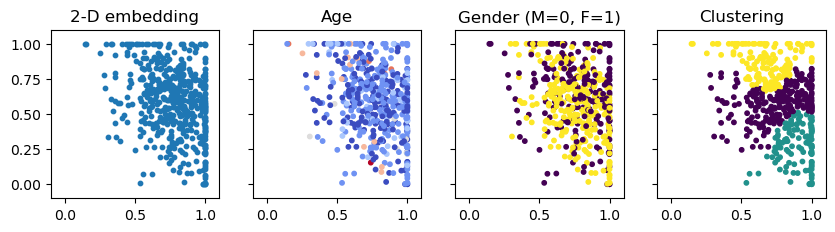

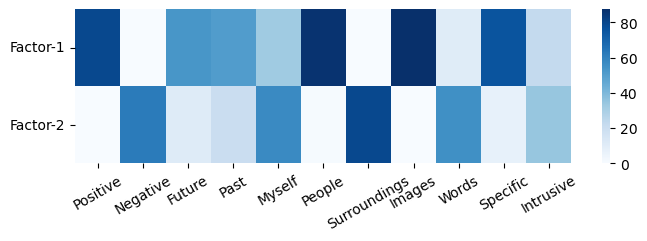

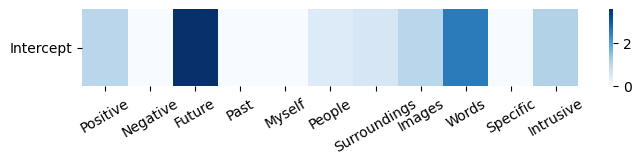

In [91]:
fig, ax = pyplot.subplots(ncols=4, nrows=1, figsize=(10, 4), sharex=True, sharey=True)
ax[0].scatter(MF_data.W[:,0], MF_data.W[:,1], s=10)
ax[0].set_xlim([-0.1, 1.1])
ax[0].set_ylim([-0.1, 1.1])
ax[0].set_aspect('equal', 'box')
ax[0].set_title('2-D embedding')
ax[1].scatter(MF_data.W[:,0], MF_data.W[:,1], c=age, cmap='coolwarm', s=10)
ax[1].set_xlim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
ax[1].set_aspect('equal', 'box')
ax[1].set_title('Age')
ax[2].scatter(MF_data.W[:,0], MF_data.W[:,1], c=gender, s=10)
ax[2].set_xlim([-0.1, 1.1])
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_aspect('equal', 'box')
ax[2].set_title('Gender (M=0, F=1)')

clustering = AgglomerativeClustering(n_clusters=3).fit(MF_data.W)
ax[3].scatter(MF_data.W[:,0], MF_data.W[:,1], c=clustering.labels_, s=10)
ax[3].set_xlim([-0.1, 1.1])
ax[3].set_ylim([-0.1, 1.1])
ax[3].set_aspect('equal', 'box')
ax[3].set_title('Clustering')
pyplot.show()

fig, ax = pyplot.subplots(figsize=(8, 2))
sns.heatmap(MF_data.Q.T, cmap='Blues', ax=ax)
ax.set_xticks(np.arange(11)+0.5)
ax.set_xticklabels(question_list, rotation=30)
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(['Factor-1', 'Factor-2'], rotation=0)
pyplot.show()

fig, ax = pyplot.subplots(figsize=(8, 1))
sns.heatmap(MF_data.Qc.T, cmap='Blues', ax=ax)
ax.set_xticks(np.arange(11)+0.5)
ax.set_xticklabels(question_list, rotation=30)
ax.set_yticks([0.5])
ax.set_yticklabels(['Intercept'], rotation=0)
pyplot.show()